# Felix prototype
**Version 0.2**   
**Date 10/11/2018**  
  
Model used : **Random Forest** Classifier on features selected using various techniques including **lasso**  
Clustering method used : **Hierarchical clustering** using **ward metric** based on 6 **NOT variable** 

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample

In [2]:
path_project = Path.home() / Path('Google Drive/Felix')
path_fig = path_project / Path("fig")
path_data = path_project / Path("data")
path_dump = path_project / Path("dump")

In [3]:
# loading data
file = path_data / Path("dataset.csv")
with Path.open(file, 'rb') as fp:
    dataset = pd.read_csv(fp,  encoding='utf-8',low_memory=False, index_col = 0)

### Features scope and selection strategy  
Features are selected using lasso on the full scope of feature.
The 50 more important features (logistic regression coef ranking) are kept regardless of their activability

In [4]:
# load feature sets
filename = path_dump / Path("dict_features_sets.sav")
with open(filename, 'rb') as fp:
     dict_features_sets = pickle.load(fp)

In [5]:
[k for k in dict_features_sets.keys()]

['all_features',
 'cdv_features',
 'additional_features',
 'insee_features',
 'insee_demographics_features',
 'insee_recreation_features',
 'cat_features',
 'quant_features',
 'non_redundant_cdv_features',
 'cdv_actionable_individual_1_features',
 'cdv_actionable_individual_2_features',
 'cdv_actionable_individual_3_features',
 'cdv_actionable_individual_4_features',
 'cdv_actionable_admin_1_features',
 'cdv_actionable_admin_2_features',
 'cdv_actionable_admin_3_features',
 'cdv_actionable_admin_4_features',
 'cdv_actionable_admin_5_features',
 'insee_recreation_actionable_admin_1_features',
 'insee_recreation_actionable_admin_3_features',
 'insee_recreation_actionable_admin_4_features',
 'insee_demographics_actionable_admin_1_features',
 'insee_demographics_actionable_admin_2_features',
 'insee_demographics_actionable_admin_3_features',
 'insee_demographics_actionable_admin_4_features',
 'insee_demographics_actionable_admin_5_features',
 'insee_environment_score_features',
 'insee_rec

In [6]:
usual_common_scope_features = dict_features_sets.get('usual_common_scope_features', set())
# retreiving actionable features from disk
cdv_actionable_individual_1_features = dict_features_sets.get('cdv_actionable_individual_1_features', set())
cdv_actionable_individual_2_features = dict_features_sets.get('cdv_actionable_individual_2_features', set())
cdv_actionable_admin_1_features = dict_features_sets.get('cdv_actionable_admin_1_features', set())
cdv_actionable_admin_2_features = dict_features_sets.get('cdv_actionable_admin_2_features', set())
insee_recreation_actionable_admin_1_features = dict_features_sets.get('insee_recreation_actionable_admin_1_features', set())
insee_recreation_actionable_admin_2_features = dict_features_sets.get('insee_recreation_actionable_admin_2_features', set())
insee_environment_actionable_admin_1_features = dict_features_sets.get('insee_environment_actionable_admin_1_features', set())
insee_environment_actionable_admin_2_features = dict_features_sets.get('insee_environment_actionable_admin_2_features', set())
insee_demographics_actionable_admin_1_features = dict_features_sets.get('insee_demographics_actionable_admin_1_features', set())
insee_demographics_actionable_admin_2_features = dict_features_sets.get('insee_demographics_actionable_admin_2_features', set())
# defining sets of actionable features
actionable_individual_1_features = cdv_actionable_individual_1_features
actionable_individual_2_features = cdv_actionable_individual_2_features
actionable_admin_1_features = cdv_actionable_admin_1_features | insee_recreation_actionable_admin_1_features | insee_environment_actionable_admin_1_features | insee_demographics_actionable_admin_1_features
actionable_admin_2_features = cdv_actionable_admin_2_features | insee_recreation_actionable_admin_2_features | insee_environment_actionable_admin_2_features | insee_demographics_actionable_admin_2_features

RFE_LogisticRegression_10_features = dict_features_sets['RFE_LogisticRegression_10_features']
RFE_LogisticRegression_20_features = dict_features_sets['RFE_LogisticRegression_20_features']
RFE_LogisticRegression_50_features = dict_features_sets['RFE_LogisticRegression_50_features']
RFE_LogisticRegression_100_features = dict_features_sets['RFE_LogisticRegression_100_features']

RFE_RandomForestClassifier_100_features = dict_features_sets['RFE_RandomForestClassifier_100_features']
RFE_RandomForestClassifier_20_features = dict_features_sets['RFE_RandomForestClassifier_20_features']
RFE_RandomForestClassifier_50_features = dict_features_sets['RFE_RandomForestClassifier_50_features']
RFE_RandomForestClassifier_10_features = dict_features_sets['RFE_RandomForestClassifier_10_features']

RFE_LinearSVC_100_features = dict_features_sets['RFE_LinearSVC_100_features']
RFE_LinearSVC_50_features =  dict_features_sets['RFE_LinearSVC_50_features']
RFE_LinearSVC_20_features =  dict_features_sets['RFE_LinearSVC_20_features']
RFE_LinearSVC_10_features =  dict_features_sets['RFE_LinearSVC_10_features']
SelectFromModel_LinearSCV_features = dict_features_sets['SelectFromModel_LinearSCV_features']
SelectFromModel_LogisticRegression_features = dict_features_sets['SelectFromModel_LogisticRegression_features']

In [7]:
print(f"The {len(SelectFromModel_LogisticRegression_features)} features obtained using lasso:")
print(f"{len(SelectFromModel_LogisticRegression_features & dict_features_sets.get('cdv_features',set()))} issues de l'étude CDV, {len(SelectFromModel_LogisticRegression_features & dict_features_sets.get('insee_features',set()))} de l'insee, {len(SelectFromModel_LogisticRegression_features & dict_features_sets.get('additional_features',set()))} calculées à partir des données insee")
print(list(SelectFromModel_LogisticRegression_features))

The 56 features obtained using lasso:
56 issues de l'étude CDV, 0 de l'insee, 0 calculées à partir des données insee
['INQROUT3_Non inquiet', 'RE_ALIM_Oui', 'INQALIM', 'TRANSFST_Oui', 'ETATSAN', 'SITUEMP3_Inactif', 'RE_VOIT_Oui', 'OPIRSA_[Nsp]', 'CDV5', 'RE_EQUI_[Nsp]', 'LIEN_2_Conjoint ou compagnon', 'INQAGRE3_Non inquiet', 'RE_VAC_nan', 'RE_MEDI_nan', 'OPIIMMIG_[Nsp]', 'SOUFFINS_Oui', 'NOT_FAMI', 'CHOIXNUC_Sans avis', 'CLASSESO_La classe moyenne supérieure', 'CADVIE', 'UDA10_DOM', 'SECURITE', 'BANQEPA_Oui', 'zau2010_nan', 'PREOTENS_Oui', 'PCSCON7_Sans conjoint', 'INQCHOMA', 'revtot7', 'CONFENTR', 'RE_LOG_Oui', 'TRAVFEM_Elles devraient travailler quand elles le désirent', 'CHERCHEM_Oui', 'RESTRICT_Oui', 'PROGRAD_nan', 'NOT_LIBR', 'VACANCES_Oui', 'NOT_PROF', 'NIVPERSO', 'PCSENQ10_Ouvrier', 'INQCHOM3_Non inquiet', 'RE_MEDI_Oui', 'HANDICAP_Oui', 'SITUFAM_Couple sans enfants', 'RE_ALIM_nan', 'INQMALAD', 'NBCHOM', 'ASSO10_2_Non adhérent', 'NB03_2_Oui, enfant de moins de 3 ans', 'SOUFFDEP_O

### Clustering method - feature used 
Hierarchical clustering is used using 6 common "NOT_" variable

In [8]:
# loading clustering
file = path_data / Path("clustTest3.csv")
with Path.open(file, 'rb') as fp:
    clustTest1 = pd.read_csv(fp,  encoding='utf-8',low_memory=False, sep=";", index_col = 0)

In [9]:
cluster_name = ["","Civiques","Equilibrés","Flâneurs","Domestiques modérés","Solitaires","Domestiques stricts"]

## Option 1 - Lasso only

In [10]:
# choosing set of features
scope = SelectFromModel_LogisticRegression_features
print(f"number of features : {len(scope)} ow actionable")
A = scope & dict_features_sets.get('cdv_actionable_admin_1_features',set()) 
B = scope & dict_features_sets.get('cdv_actionable_individual_1_features',set()) 
print(f"- at administrative level 1 : \t{len(A)}\n- at individual level 1 : \t{len(B)}")

number of features : 56 ow actionable
- at administrative level 1 : 	27
- at individual level 1 : 	25


### Training set and test set preparation

In [11]:
df = dataset.loc[:,:]
# reducing problem to a 2 class classification problem
df["HEUREUX_CLF"] = 0
df.loc[df["HEUREUX"]==4, "HEUREUX_CLF"] = 1
df.loc[df["HEUREUX"]==3, "HEUREUX_CLF"] = 1
df.loc[df["HEUREUX"]==5, "HEUREUX_CLF"] = None

scope = scope & set(dataset.columns)
n_max = 2000

df = df.loc[:,scope | {"HEUREUX_CLF"} ].dropna()
features = df.loc[:,scope ].columns

X = df.loc[:,scope]
y = df["HEUREUX_CLF"]


Xs, ys = resample(X, y, random_state=42)

Xs = Xs.iloc[0:n_max,:]
ys = ys.iloc[0:n_max]

X_train, X_test, y_train, y_test = train_test_split(Xs, ys, 
                                                    test_size=0.2, 
                                                    random_state=42
                                                   )

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f"Number exemple: {y.shape[0]}\n- training set: \
{y_train.shape[0]}\n- test set: {y_test.shape[0]}")
print(f"Number of features: p={X_train.shape[1]}")
print(f"Number of class: {len(np.unique(y))}")
for c in np.unique(y):
    print(f"class {c:0.0f} : {100*np.sum(y==c)/len(y):0.1f}%")

Number exemple: 10788
- training set: 1600
- test set: 400
Number of features: p=56
Number of class: 2
class 0 : 35.0%
class 1 : 65.0%


### Learning and model performance evaluation on full dataset (before clustering)


In [12]:
startTime = time.time()
n_estimators_range = [32,64,128,256,512]
max_depth_range = [4,8,16,32,64] 
param_grid = dict(n_estimators=n_estimators_range, max_depth = max_depth_range)

params = {'max_features' :'sqrt', 'random_state' : 32,
          'min_samples_split' : 2, 'class_weight' : 'balanced'}
clf = RandomForestClassifier(**params)

grid = GridSearchCV(clf, scoring='accuracy', param_grid=param_grid)
grid.fit(X_train, y_train)
print(f"Determination of optimal hyperparameters in {time.time() - startTime:0.1f} s")
print(f"Optimal values are {grid.best_params_} \n\
Accuracy Score of cross valdation {100*grid.best_score_:0.2f}%")

# Learning on full training set with optimals hyperparameters and score on test set
params = {'max_features' :'sqrt', 'random_state' : 32, 
          'min_samples_split' : 2, 'class_weight' : 'balanced',
          'n_estimators' : grid.best_params_['n_estimators'],
          'max_depth' : grid.best_params_['max_depth']}
clf = RandomForestClassifier(**params).fit(X_train, y_train)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

print(f"Random Forest, p={X_train.shape[1]}")
accuracy = clf.score(X_test, y_test)
f1 = f1_score(y_test, y_test_pred)
p = precision_score(y_test, y_test_pred)
r = recall_score(y_test, y_test_pred)
print(f"Model score\n- Accuracy : {accuracy*100:0.1f} %")
print(f"- Precision : {p*100:0.1f} % (Happy # positive class)")
print(f"- Recall : {r*100:0.1f} %")
print(f"- F1 score : {f1*100:0.1f} %")
res_full  = {
    'f1_score' : f1,
    'accuracy' : accuracy,
    'precision' : p,
    'recall' : r
}

Determination of optimal hyperparameters in 43.2 s
Optimal values are {'max_depth': 16, 'n_estimators': 256} 
Accuracy Score of cross valdation 75.56%
Random Forest, p=56
Model score
- Accuracy : 73.5 %
- Precision : 73.8 % (Happy # positive class)
- Recall : 90.1 %
- F1 score : 81.1 %


Feature ranking:


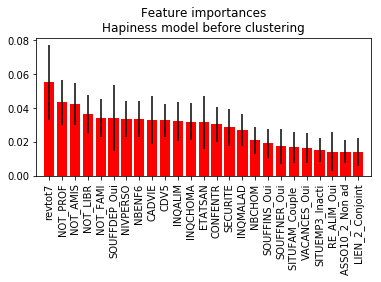

1. feature 27 -revtot7- (0.055216)
	Actionable at individual level (2)
	Actionable at administrative level (2)
2. feature 36 -NOT_PROF- (0.043599)
	Actionable at individual level (1)
	Actionable at administrative level (2)
3. feature 49 -NOT_AMIS- (0.042551)
	Actionable at individual level (1)
	Actionable at administrative level (2)
4. feature 34 -NOT_LIBR- (0.036881)
	Actionable at individual level (1)
	Actionable at administrative level (1)
5. feature 16 -NOT_FAMI- (0.034543)
	Actionable at individual level (1)
	Actionable at administrative level (2)
6. feature 48 -SOUFFDEP_Oui- (0.034192)
	Actionable at individual level (2)
	Actionable at administrative level (1)
7. feature 37 -NIVPERSO- (0.033697)
	Actionable at individual level (2)
	Actionable at administrative level (2)
8. feature 54 -NBENF6- (0.033558)
	Actionable at individual level (2)
	Actionable at administrative level (2)
9. feature 19 -CADVIE- (0.032957)
	Actionable at individual level (1)
	Actionable at administrative lev

In [13]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features_name = np.array(features)
features_short_name_sorted = [ name[:15] for name in features_name[indices]]
n_features_max = 25
n_features = min(X.shape[1],n_features_max)
print("Feature ranking:")

# Plot the feature importances of the forest
plt.figure()
plt.gcf().subplots_adjust(bottom=0.4)
plt.title("Feature importances\nHapiness model before clustering")
plt.bar(range(n_features), importances[indices][:n_features],
        color="r", yerr=std[indices[:n_features]], align="center")
plt.xticks(range(n_features), features_short_name_sorted[:n_features], rotation=90)
plt.xlim([-1, n_features])
filename = path_fig / Path("feature_importance_option1.jpg")
plt.savefig(filename, format='jpg')
plt.show()

for f in range(min(X.shape[1],n_features_max)):
    print("%d. feature %d -%s- (%f)" % (f + 1, indices[f],features_name[indices[f]], importances[indices[f]]))
    if features_name[indices[f]] in actionable_individual_1_features:
        print("\tActionable at individual level (1)")
    if features_name[indices[f]] in actionable_individual_2_features:
        print("\tActionable at individual level (2)")
    if features_name[indices[f]] in actionable_admin_1_features:
        print("\tActionable at administrative level (1)")
    if features_name[indices[f]] in actionable_admin_2_features:
        print("\tActionable at administrative level (2)")


In [14]:
print(f"number of features : {len(scope)} ow actionnable")
A = scope & dict_features_sets.get('cdv_actionable_admin_1_features',set()) 
B = scope & dict_features_sets.get('cdv_actionable_individual_1_features',set()) 
print(f"- at administrative level 1 : \t{len(A)}\n- at individual level 1 : \t{len(B)}")
important_features = set(features_name[indices][:10])
C = A & important_features
D = B & important_features
print(f"- at administrative level 1 in top 10: \t{len(C)}\n- at individual level 1 in top 10: \t{len(D)}")

number of features : 56 ow actionnable
- at administrative level 1 : 	27
- at individual level 1 : 	25
- at administrative level 1 in top 10: 	4
- at individual level 1 in top 10: 	5


### Learning and model performance evaluation on each clusters

In [15]:
n_estimators_range = [16,32,64,128]
max_depth_range = [2,4,8,16,32,64] 
param_grid = dict(n_estimators=n_estimators_range, max_depth = max_depth_range)
params = {'max_features' :'sqrt', 
          'random_state' : 32, 
          'min_samples_split' : 2, 
          'class_weight' : 'balanced'
         }
#scope = ( SelectFromModel_LogisticRegression_features )  & set(dataset.columns)
features = df.loc[:,scope].columns

In [16]:
score_clustering_methods = []
clustering_methods = clustTest1.columns[2:3]

for method in clustering_methods:
    print("--------------------------------------------")
    print(f"\nAnalysis cluster method {method}")
    cluster_list = clustTest1[method].unique()
    print(f"liste of clusters : {cluster_list}")
    score_cluster = []
    for cluster in cluster_list:
        index_scope = clustTest1.loc[clustTest1[method]==cluster,:].index
        print(f"cluster {cluster} '{cluster_name[cluster]}' : {len(index_scope)} elements")
        
        Xc = X.loc[index_scope.intersection(X.index),:]
        yc = y[index_scope.intersection(X.index)]
        
        Xs, ys = resample(Xc, yc, random_state=42)
        
        Xs = Xs.iloc[0:n_max,:]
        ys = ys.iloc[0:n_max]
        
        X_train, X_test, y_train, y_test = train_test_split(Xs, ys,
                                                            test_size=0.2, 
                                                            random_state=42)

        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
                
        print(f"Number exemple: {ys.shape[0]}\n\
        - training set: {y_train.shape[0]}\n\
        - test set: {y_test.shape[0]}")
        print(f"Number of features: p={X_train.shape[1]}")
        print(f"Number of class: {len(np.unique(y))}")
        for c in np.unique(y):
            print(f"class {c:0.0f} : {100*np.sum(yc==c)/len(yc):0.1f}%")
            
            
        startTime = time.time()
        clf = RandomForestClassifier(**params)
        grid = GridSearchCV(clf, 
                            scoring='accuracy', 
                            param_grid=param_grid)

        grid.fit(X_train, y_train)
        print(f"Optimal values are {grid.best_params_} \n\
cross validation score {100*grid.best_score_:0.2f}%")
        print()

        # Learning on full training set with optimals hyperparameters and score on test set
        params_opt = {'max_features' :'sqrt', 'random_state' : 32, 
                      'min_samples_split' : 2, 'class_weight' : 'balanced',
                      'n_estimators' : grid.best_params_['n_estimators'],
                      'max_depth' : grid.best_params_['max_depth']}
        clf = RandomForestClassifier(**params_opt).fit(X_train, y_train)

            
        y_test_pred = clf.predict(X_test)
        accuracy = clf.score(X_test, y_test)
        f1 = f1_score(y_test, y_test_pred)
        p = precision_score(y_test, y_test_pred)
        r = recall_score(y_test, y_test_pred)            

        res  = {'f1_score' : f1,
                'accuracy' : accuracy,
                'precision' : p,
                'recall' : r}

        
        importances = clf.feature_importances_
        std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                     axis=0)
        indices = np.argsort(importances)[::-1]
        features_name = np.array(features)
        
        cl = {'cluster' : cluster,
              'size' : len(index_scope),
              'model' : 'RandomForestClassifier',
              'params' : params_opt,
              'metrics' : res,
              'importances' : importances,
              'sdt' : std,
              'indices' : indices,
              'features_name' : features_name
             }
         
        score_cluster.append(cl)        
        
        
    d = {'clustering_method' : method,
         'cluster_scores' : score_cluster
        }
    score_clustering_methods.append(d) 

--------------------------------------------

Analysis cluster method clust3
liste of clusters : [2 4 6 1 3 5]
cluster 2 'Equilibrés' : 3053 elements
Number exemple: 2000
        - training set: 1600
        - test set: 400
Number of features: p=56
Number of class: 2
class 0 : 34.7%
class 1 : 65.3%
Optimal values are {'max_depth': 16, 'n_estimators': 64} 
cross validation score 80.06%

cluster 4 'Domestiques modérés' : 2359 elements
Number exemple: 2000
        - training set: 1600
        - test set: 400
Number of features: p=56
Number of class: 2
class 0 : 32.7%
class 1 : 67.3%
Optimal values are {'max_depth': 32, 'n_estimators': 128} 
cross validation score 84.38%

cluster 6 'Domestiques stricts' : 2313 elements
Number exemple: 2000
        - training set: 1600
        - test set: 400
Number of features: p=56
Number of class: 2
class 0 : 32.8%
class 1 : 67.2%
Optimal values are {'max_depth': 16, 'n_estimators': 128} 
cross validation score 83.56%

cluster 1 'Civiques' : 528 elements

### Performance gain obtained using clustering

In [17]:
# F1 score
for score_method in score_clustering_methods:
    print(f"method {score_method['clustering_method']}:")
    average_score = 0
    total_size = 0
    for i, score_cluster in enumerate(score_method['cluster_scores']):
        print(f"cluster {score_cluster['cluster']} '{cluster_name[score_cluster['cluster']]}' : ({score_cluster['size']}), f1 macro {100*score_cluster['metrics']['f1_score']:0.1f}%")  
        average_score += score_cluster['metrics']['f1_score']*score_cluster['size']
        total_size += score_cluster['size']
        
    average_score = average_score / total_size
    print(f"average f1 on clusters {100*average_score:0.1f}% gain {100*(average_score-res_full['f1_score']):0.1f}\n")  

method clust3:
cluster 2 'Equilibrés' : (3053), f1 macro 90.0%
cluster 4 'Domestiques modérés' : (2359), f1 macro 92.0%
cluster 6 'Domestiques stricts' : (2313), f1 macro 92.0%
cluster 1 'Civiques' : (528), f1 macro 89.6%
cluster 3 'Flâneurs' : (1384), f1 macro 92.1%
cluster 5 'Solitaires' : (1494), f1 macro 89.5%
average f1 on clusters 91.0% gain 9.9



In [18]:
# accuracy
for score_method in score_clustering_methods:
    print(f"method {score_method['clustering_method']}:")
    average_score = 0
    total_size = 0
    for i, score_cluster in enumerate(score_method['cluster_scores']):
        print(f"cluster {score_cluster['cluster']} '{cluster_name[score_cluster['cluster']]}' : ({score_cluster['size']}) accuracy {100*score_cluster['metrics']['accuracy']:0.1f}%")  
        average_score = average_score + score_cluster['metrics']['accuracy']*score_cluster['size']
        total_size += score_cluster['size']
    average_score = average_score / total_size
    print(f"average accuracy on clusters {100*average_score:0.1f}% gain {100*(average_score-res_full['accuracy']):0.1f}\n")  

method clust3:
cluster 2 'Equilibrés' : (3053) accuracy 86.0%
cluster 4 'Domestiques modérés' : (2359) accuracy 88.2%
cluster 6 'Domestiques stricts' : (2313) accuracy 88.2%
cluster 1 'Civiques' : (528) accuracy 90.1%
cluster 3 'Flâneurs' : (1384) accuracy 88.3%
cluster 5 'Solitaires' : (1494) accuracy 87.5%
average accuracy on clusters 87.6% gain 14.1



### Feature importance of the models & actionable variables

method clust3:
cluster 2 (3053), f1 macro 90.0%
top 15 features:


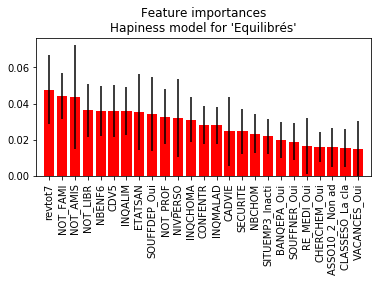

1. feature 27 -revtot7- (0.047657)
	Actionable at individual level (2)
	Actionable at administrative level (2)
2. feature 16 -NOT_FAMI- (0.044059)
	Actionable at individual level (1)
	Actionable at administrative level (2)
3. feature 49 -NOT_AMIS- (0.043665)
	Actionable at individual level (1)
	Actionable at administrative level (2)
4. feature 34 -NOT_LIBR- (0.036328)
	Actionable at individual level (1)
	Actionable at administrative level (1)
5. feature 54 -NBENF6- (0.035803)
	Actionable at individual level (2)
	Actionable at administrative level (2)
6. feature 8 -CDV5- (0.035799)
	Actionable at individual level (2)
	Actionable at administrative level (1)
7. feature 2 -INQALIM- (0.035799)
	Actionable at individual level (1)
	Actionable at administrative level (1)
8. feature 4 -ETATSAN- (0.035452)
	Actionable at individual level (1)
	Actionable at administrative level (1)
9. feature 48 -SOUFFDEP_Oui- (0.034260)
	Actionable at individual level (2)
	Actionable at administrative level (1)


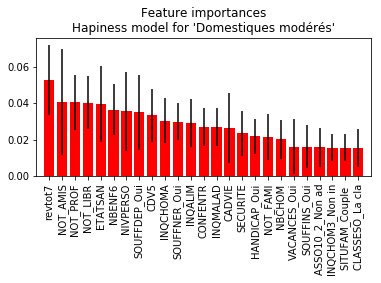

1. feature 27 -revtot7- (0.052969)
	Actionable at individual level (2)
	Actionable at administrative level (2)
2. feature 49 -NOT_AMIS- (0.040807)
	Actionable at individual level (1)
	Actionable at administrative level (2)
3. feature 36 -NOT_PROF- (0.040491)
	Actionable at individual level (1)
	Actionable at administrative level (2)
4. feature 34 -NOT_LIBR- (0.040371)
	Actionable at individual level (1)
	Actionable at administrative level (1)
5. feature 4 -ETATSAN- (0.039456)
	Actionable at individual level (1)
	Actionable at administrative level (1)
6. feature 54 -NBENF6- (0.036584)
	Actionable at individual level (2)
	Actionable at administrative level (2)
7. feature 37 -NIVPERSO- (0.035630)
	Actionable at individual level (2)
	Actionable at administrative level (2)
8. feature 48 -SOUFFDEP_Oui- (0.034990)
	Actionable at individual level (2)
	Actionable at administrative level (1)
9. feature 8 -CDV5- (0.033469)
	Actionable at individual level (2)
	Actionable at administrative level (1

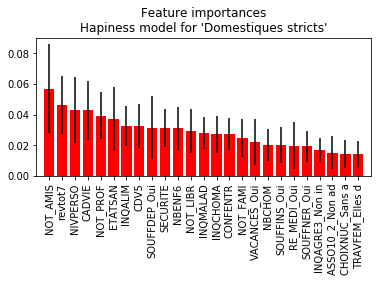

1. feature 49 -NOT_AMIS- (0.057038)
	Actionable at individual level (1)
	Actionable at administrative level (2)
2. feature 27 -revtot7- (0.046253)
	Actionable at individual level (2)
	Actionable at administrative level (2)
3. feature 37 -NIVPERSO- (0.043320)
	Actionable at individual level (2)
	Actionable at administrative level (2)
4. feature 19 -CADVIE- (0.042762)
	Actionable at individual level (1)
	Actionable at administrative level (1)
5. feature 36 -NOT_PROF- (0.039357)
	Actionable at individual level (1)
	Actionable at administrative level (2)
6. feature 4 -ETATSAN- (0.037085)
	Actionable at individual level (1)
	Actionable at administrative level (1)
7. feature 2 -INQALIM- (0.032531)
	Actionable at individual level (1)
	Actionable at administrative level (1)
8. feature 8 -CDV5- (0.032395)
	Actionable at individual level (2)
	Actionable at administrative level (1)
9. feature 48 -SOUFFDEP_Oui- (0.031513)
	Actionable at individual level (2)
	Actionable at administrative level (1)


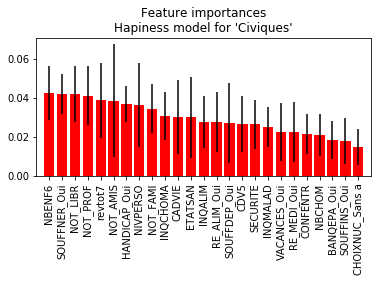

1. feature 54 -NBENF6- (0.042514)
	Actionable at individual level (2)
	Actionable at administrative level (2)
2. feature 53 -SOUFFNER_Oui- (0.042101)
	Actionable at individual level (2)
	Actionable at administrative level (1)
3. feature 34 -NOT_LIBR- (0.041892)
	Actionable at individual level (1)
	Actionable at administrative level (1)
4. feature 36 -NOT_PROF- (0.041140)
	Actionable at individual level (1)
	Actionable at administrative level (2)
5. feature 27 -revtot7- (0.038693)
	Actionable at individual level (2)
	Actionable at administrative level (2)
6. feature 49 -NOT_AMIS- (0.038585)
	Actionable at individual level (1)
	Actionable at administrative level (2)
7. feature 41 -HANDICAP_Oui- (0.036950)
	Actionable at administrative level (2)
8. feature 37 -NIVPERSO- (0.036182)
	Actionable at individual level (2)
	Actionable at administrative level (2)
9. feature 16 -NOT_FAMI- (0.034522)
	Actionable at individual level (1)
	Actionable at administrative level (2)
10. feature 26 -INQCHOM

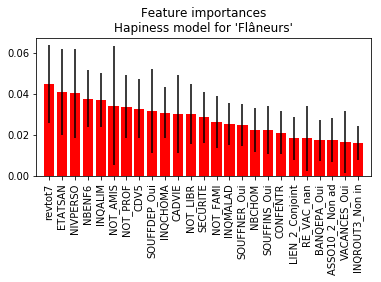

1. feature 27 -revtot7- (0.044798)
	Actionable at individual level (2)
	Actionable at administrative level (2)
2. feature 4 -ETATSAN- (0.040740)
	Actionable at individual level (1)
	Actionable at administrative level (1)
3. feature 37 -NIVPERSO- (0.040127)
	Actionable at individual level (2)
	Actionable at administrative level (2)
4. feature 54 -NBENF6- (0.037606)
	Actionable at individual level (2)
	Actionable at administrative level (2)
5. feature 2 -INQALIM- (0.037001)
	Actionable at individual level (1)
	Actionable at administrative level (1)
6. feature 49 -NOT_AMIS- (0.034235)
	Actionable at individual level (1)
	Actionable at administrative level (2)
7. feature 36 -NOT_PROF- (0.033737)
	Actionable at individual level (1)
	Actionable at administrative level (2)
8. feature 8 -CDV5- (0.032764)
	Actionable at individual level (2)
	Actionable at administrative level (1)
9. feature 48 -SOUFFDEP_Oui- (0.031735)
	Actionable at individual level (2)
	Actionable at administrative level (1)


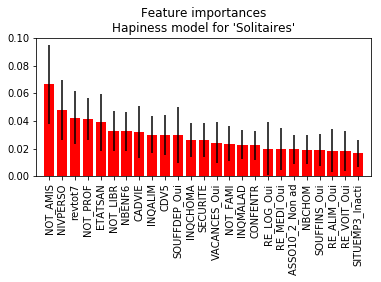

1. feature 49 -NOT_AMIS- (0.066353)
	Actionable at individual level (1)
	Actionable at administrative level (2)
2. feature 37 -NIVPERSO- (0.047735)
	Actionable at individual level (2)
	Actionable at administrative level (2)
3. feature 27 -revtot7- (0.042365)
	Actionable at individual level (2)
	Actionable at administrative level (2)
4. feature 36 -NOT_PROF- (0.041131)
	Actionable at individual level (1)
	Actionable at administrative level (2)
5. feature 4 -ETATSAN- (0.038959)
	Actionable at individual level (1)
	Actionable at administrative level (1)
6. feature 34 -NOT_LIBR- (0.032890)
	Actionable at individual level (1)
	Actionable at administrative level (1)
7. feature 54 -NBENF6- (0.032387)
	Actionable at individual level (2)
	Actionable at administrative level (2)
8. feature 19 -CADVIE- (0.031988)
	Actionable at individual level (1)
	Actionable at administrative level (1)
9. feature 2 -INQALIM- (0.030055)
	Actionable at individual level (1)
	Actionable at administrative level (1)
1

In [19]:
# Feature importance by cluster
for score_method in score_clustering_methods:
    print(f"method {score_method['clustering_method']}:")
    for i, score_cluster in enumerate(score_method['cluster_scores']):
        print(f"cluster {score_cluster['cluster']} ({score_cluster['size']}), f1 macro {100*score_cluster['metrics']['f1_score']:0.1f}%")
        print(f"top 15 features:")
        indices = score_cluster['indices']
        features_name = score_cluster['features_name']
        importances = score_cluster['importances']
        features_short_name_sorted = [ name[:15] for name in features_name[indices]]
          
        # Plot the feature importances of the forest       
        plt.figure()
        plt.gcf().subplots_adjust(bottom=0.4)
        plt.title(f"Feature importances\nHapiness model for '{cluster_name[score_cluster['cluster']]}'")
        plt.bar(range(n_features), importances[indices][:n_features],
                color="r", yerr=std[indices][:n_features], align="center")
        plt.xticks(range(n_features), features_short_name_sorted[:n_features], rotation=90)
        plt.xlim([-1, n_features])
        filename = path_fig / Path(f"feature_importance_cluster_{score_cluster['cluster']}_option1.jpg")
        plt.savefig(filename, format='jpg')
        plt.show()
                
        for f in range(n_features_max):
            print("%d. feature %d -%s- (%f)" % (f + 1, indices[f],features_name[indices[f]], importances[indices[f]]))
            if features_name[indices[f]] in actionable_individual_1_features:
                print("\tActionable at individual level (1)")
            if features_name[indices[f]] in actionable_individual_2_features:
                print("\tActionable at individual level (2)")
            if features_name[indices[f]] in actionable_admin_1_features:
                print("\tActionable at administrative level (1)")
            if features_name[indices[f]] in actionable_admin_2_features:
                print("\tActionable at administrative level (2)")

## Option 2

In [20]:
# choosing set of features
scope = dict_features_sets.get('insee_environment_score_features', set())
scope = scope | dict_features_sets.get('insee_recreation_score_features',set()) 
#scope = scope | dict_features_sets.get('cdv_actionable_admin_1_features',set()) 
scope = scope | RFE_LogisticRegression_20_features
print(f"number of features : {len(scope)} ow actionable")
A = scope & dict_features_sets.get('cdv_actionable_admin_1_features',set()) 
B = scope & dict_features_sets.get('cdv_actionable_individual_1_features',set()) 
print(f"- at administrative level 1 : \t{len(A)}\n- at individual level 1 : \t{len(B)}")

number of features : 34 ow actionable
- at administrative level 1 : 	11
- at individual level 1 : 	9


In [21]:
df = dataset.loc[:,:]
# reducing problem to a 2 class classification problem
df["HEUREUX_CLF"] = 0
df.loc[df["HEUREUX"]==4, "HEUREUX_CLF"] = 1
df.loc[df["HEUREUX"]==3, "HEUREUX_CLF"] = 1
df.loc[df["HEUREUX"]==5, "HEUREUX_CLF"] = None

scope = scope & set(dataset.columns)
n_max = 2000

df = df.loc[:,scope | {"HEUREUX_CLF"} ].dropna()
features = df.loc[:,scope ].columns

X = df.loc[:,scope]
y = df["HEUREUX_CLF"]


Xs, ys = resample(X, y, random_state=42)

Xs = Xs.iloc[0:n_max,:]
ys = ys.iloc[0:n_max]

X_train, X_test, y_train, y_test = train_test_split(Xs, ys, 
                                                    test_size=0.2, 
                                                    random_state=42
                                                   )

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f"Number exemple: {y.shape[0]}\n- training set: \
{y_train.shape[0]}\n- test set: {y_test.shape[0]}")
print(f"Number of features: p={X_train.shape[1]}")
print(f"Number of class: {len(np.unique(y))}")
for c in np.unique(y):
    print(f"class {c:0.0f} : {100*np.sum(y==c)/len(y):0.1f}%")

Number exemple: 10858
- training set: 1600
- test set: 400
Number of features: p=34
Number of class: 2
class 0 : 34.9%
class 1 : 65.1%


In [22]:
startTime = time.time()
n_estimators_range = [32,64,128,256,512]
max_depth_range = [4,8,16,32,64] 
param_grid = dict(n_estimators=n_estimators_range, max_depth = max_depth_range)

params = {'max_features' :'sqrt', 'random_state' : 32,
          'min_samples_split' : 2, 'class_weight' : 'balanced'}
clf = RandomForestClassifier(**params)

grid = GridSearchCV(clf, scoring='accuracy', param_grid=param_grid)
grid.fit(X_train, y_train)
print(f"Determination of optimal hyperparameters in {time.time() - startTime:0.1f} s")
print(f"Optimal values are {grid.best_params_} \n\
Accuracy Score of cross valdation {100*grid.best_score_:0.2f}%")

# Learning on full training set with optimals hyperparameters and score on test set
params = {'max_features' :'sqrt', 'random_state' : 32, 
          'min_samples_split' : 2, 'class_weight' : 'balanced',
          'n_estimators' : grid.best_params_['n_estimators'],
          'max_depth' : grid.best_params_['max_depth']}
clf = RandomForestClassifier(**params).fit(X_train, y_train)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

print(f"Random Forest, p={X_train.shape[1]}")
accuracy = clf.score(X_test, y_test)
f1 = f1_score(y_test, y_test_pred)
p = precision_score(y_test, y_test_pred)
r = recall_score(y_test, y_test_pred)
print(f"Model score\n- Accuracy : {accuracy*100:0.1f} %")
print(f"- Precision : {p*100:0.1f} % (Happy # positive class)")
print(f"- Recall : {r*100:0.1f} %")
print(f"- F1 score : {f1*100:0.1f} %")
res_full  = {
    'f1_score' : f1,
    'accuracy' : accuracy,
    'precision' : p,
    'recall' : r
}

Determination of optimal hyperparameters in 63.2 s
Optimal values are {'max_depth': 16, 'n_estimators': 256} 
Accuracy Score of cross valdation 77.25%
Random Forest, p=34
Model score
- Accuracy : 73.5 %
- Precision : 71.9 % (Happy # positive class)
- Recall : 94.0 %
- F1 score : 81.5 %


Feature ranking:


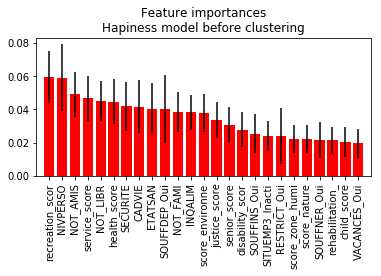

1. feature 13 -recreation_score- (0.059650)
2. feature 21 -NIVPERSO- (0.059020)
	Actionable at individual level (2)
	Actionable at administrative level (2)
3. feature 28 -NOT_AMIS- (0.049001)
	Actionable at individual level (1)
	Actionable at administrative level (2)
4. feature 11 -service_score- (0.046573)
5. feature 19 -NOT_LIBR- (0.045039)
	Actionable at individual level (1)
	Actionable at administrative level (1)
6. feature 26 -health_score- (0.044641)
7. feature 12 -SECURITE- (0.041818)
	Actionable at individual level (2)
	Actionable at administrative level (1)
8. feature 10 -CADVIE- (0.041653)
	Actionable at individual level (1)
	Actionable at administrative level (1)
9. feature 2 -ETATSAN- (0.040500)
	Actionable at individual level (1)
	Actionable at administrative level (1)
10. feature 27 -SOUFFDEP_Oui- (0.040179)
	Actionable at individual level (2)
	Actionable at administrative level (1)
11. feature 9 -NOT_FAMI- (0.038618)
	Actionable at individual level (1)
	Actionable at adm

In [23]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features_name = np.array(features)
features_short_name_sorted = [ name[:15] for name in features_name[indices]]
print("Feature ranking:")

n_features_max = 25
n_features = min(X.shape[1],n_features_max)

# Plot the feature importances of the forest

plt.figure()
plt.gcf().subplots_adjust(bottom=0.4)
plt.title("Feature importances\nHapiness model before clustering")
plt.bar(range(n_features), importances[indices][:n_features],
        color="r", yerr=std[indices[:n_features]], align="center")
plt.xticks(range(n_features), features_short_name_sorted[:n_features], rotation=90)
plt.xlim([-1, n_features])
filename = path_fig / Path("feature_importance_option2.jpg")
plt.savefig(filename, format='jpg')
plt.show()

for f in range(min(X.shape[1],n_features_max)):
    print("%d. feature %d -%s- (%f)" % (f + 1, indices[f],features_name[indices[f]], importances[indices[f]]))
    if features_name[indices[f]] in actionable_individual_1_features:
        print("\tActionable at individual level (1)")
    if features_name[indices[f]] in actionable_individual_2_features:
        print("\tActionable at individual level (2)")
    if features_name[indices[f]] in actionable_admin_1_features:
        print("\tActionable at administrative level (1)")
    if features_name[indices[f]] in actionable_admin_2_features:
        print("\tActionable at administrative level (2)")



In [24]:
print(f"number of features : {len(scope)} ow actionnable")
A = scope & dict_features_sets.get('cdv_actionable_admin_1_features',set()) 
B = scope & dict_features_sets.get('cdv_actionable_individual_1_features',set()) 
print(f"- at administrative level 1 : \t{len(A)}\n- at individual level 1 : \t{len(B)}")
important_features = set(features_name[indices][:10])
C = A & important_features
D = B & important_features
print(f"- at administrative level 1 in top 10: \t{len(C)}\n- at individual level 1 in top 10: \t{len(D)}")

number of features : 34 ow actionnable
- at administrative level 1 : 	11
- at individual level 1 : 	9
- at administrative level 1 in top 10: 	5
- at individual level 1 in top 10: 	4


In [25]:
n_estimators_range = [16,32,64,128]
max_depth_range = [2,4,8,16,32,64] 
param_grid = dict(n_estimators=n_estimators_range, max_depth = max_depth_range)
params = {'max_features' :'sqrt', 
          'random_state' : 32, 
          'min_samples_split' : 2, 
          'class_weight' : 'balanced'
         }
#scope = ( SelectFromModel_LogisticRegression_features )  & set(dataset.columns)
features = df.loc[:,scope].columns

In [26]:
score_clustering_methods = []
clustering_methods = clustTest1.columns[2:3]

for method in clustering_methods:
    print("--------------------------------------------")
    print(f"\nAnalysis cluster method {method}")
    cluster_list = clustTest1[method].unique()
    print(f"liste of clusters : {cluster_list}")
    score_cluster = []
    for cluster in cluster_list:
        index_scope = clustTest1.loc[clustTest1[method]==cluster,:].index
        print(f"cluster {cluster} '{cluster_name[cluster]}' : {len(index_scope)} elements")
        
        Xc = X.loc[index_scope.intersection(X.index),:]
        yc = y[index_scope.intersection(X.index)]
        
        Xs, ys = resample(Xc, yc, random_state=42)
        
        Xs = Xs.iloc[0:n_max,:]
        ys = ys.iloc[0:n_max]
        
        X_train, X_test, y_train, y_test = train_test_split(Xs, ys,
                                                            test_size=0.2, 
                                                            random_state=42)

        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
                
        print(f"Number exemple: {ys.shape[0]}\n\
        - training set: {y_train.shape[0]}\n\
        - test set: {y_test.shape[0]}")
        print(f"Number of features: p={X_train.shape[1]}")
        print(f"Number of class: {len(np.unique(y))}")
        for c in np.unique(y):
            print(f"class {c:0.0f} : {100*np.sum(yc==c)/len(yc):0.1f}%")
            
            
        startTime = time.time()
        clf = RandomForestClassifier(**params)
        grid = GridSearchCV(clf, 
                            scoring='accuracy', 
                            param_grid=param_grid)

        grid.fit(X_train, y_train)
        print(f"Optimal values are {grid.best_params_} \n\
cross validation score {100*grid.best_score_:0.2f}%")
        print()

        # Learning on full training set with optimals hyperparameters and score on test set
        params_opt = {'max_features' :'sqrt', 'random_state' : 32, 
                      'min_samples_split' : 2, 'class_weight' : 'balanced',
                      'n_estimators' : grid.best_params_['n_estimators'],
                      'max_depth' : grid.best_params_['max_depth']}
        clf = RandomForestClassifier(**params_opt).fit(X_train, y_train)

            
        y_test_pred = clf.predict(X_test)
        accuracy = clf.score(X_test, y_test)
        f1 = f1_score(y_test, y_test_pred)
        p = precision_score(y_test, y_test_pred)
        r = recall_score(y_test, y_test_pred)            

        res  = {'f1_score' : f1,
                'accuracy' : accuracy,
                'precision' : p,
                'recall' : r}

        
        importances = clf.feature_importances_
        std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                     axis=0)
        indices = np.argsort(importances)[::-1]
        features_name = np.array(features)
        
        cl = {'cluster' : cluster,
              'size' : len(index_scope),
              'model' : 'RandomForestClassifier',
              'params' : params_opt,
              'metrics' : res,
              'importances' : importances,
              'sdt' : std,
              'indices' : indices,
              'features_name' : features_name
             }
         
        score_cluster.append(cl)        
        
        
    d = {'clustering_method' : method,
         'cluster_scores' : score_cluster
        }
    score_clustering_methods.append(d) 

--------------------------------------------

Analysis cluster method clust3
liste of clusters : [2 4 6 1 3 5]
cluster 2 'Equilibrés' : 3053 elements
Number exemple: 2000
        - training set: 1600
        - test set: 400
Number of features: p=34
Number of class: 2
class 0 : 34.7%
class 1 : 65.3%
Optimal values are {'max_depth': 16, 'n_estimators': 128} 
cross validation score 81.69%

cluster 4 'Domestiques modérés' : 2359 elements
Number exemple: 2000
        - training set: 1600
        - test set: 400
Number of features: p=34
Number of class: 2
class 0 : 32.7%
class 1 : 67.3%
Optimal values are {'max_depth': 32, 'n_estimators': 128} 
cross validation score 84.50%

cluster 6 'Domestiques stricts' : 2313 elements
Number exemple: 2000
        - training set: 1600
        - test set: 400
Number of features: p=34
Number of class: 2
class 0 : 32.7%
class 1 : 67.3%
Optimal values are {'max_depth': 16, 'n_estimators': 64} 
cross validation score 83.56%

cluster 1 'Civiques' : 528 elements

In [27]:
# F1 score
for score_method in score_clustering_methods:
    print(f"method {score_method['clustering_method']}:")
    average_score = 0
    total_size = 0
    for i, score_cluster in enumerate(score_method['cluster_scores']):
        print(f"cluster {score_cluster['cluster']} '{cluster_name[score_cluster['cluster']]}' : ({score_cluster['size']}), f1 macro {100*score_cluster['metrics']['f1_score']:0.1f}%")  
        average_score += score_cluster['metrics']['f1_score']*score_cluster['size']
        total_size += score_cluster['size']
        
    average_score = average_score / total_size
    print(f"average f1 on clusters {100*average_score:0.1f}% gain {100*(average_score-res_full['f1_score']):0.1f}\n")  

method clust3:
cluster 2 'Equilibrés' : (3053), f1 macro 87.4%
cluster 4 'Domestiques modérés' : (2359), f1 macro 89.7%
cluster 6 'Domestiques stricts' : (2313), f1 macro 92.5%
cluster 1 'Civiques' : (528), f1 macro 86.0%
cluster 3 'Flâneurs' : (1384), f1 macro 93.0%
cluster 5 'Solitaires' : (1494), f1 macro 89.5%
average f1 on clusters 89.9% gain 8.4



In [28]:
# accuracy
for score_method in score_clustering_methods:
    print(f"method {score_method['clustering_method']}:")
    average_score = 0
    total_size = 0
    for i, score_cluster in enumerate(score_method['cluster_scores']):
        print(f"cluster {score_cluster['cluster']} '{cluster_name[score_cluster['cluster']]}' : ({score_cluster['size']}) accuracy {100*score_cluster['metrics']['accuracy']:0.1f}%")  
        average_score = average_score + score_cluster['metrics']['accuracy']*score_cluster['size']
        total_size += score_cluster['size']
    average_score = average_score / total_size
    print(f"average accuracy on clusters {100*average_score:0.1f}% gain {100*(average_score-res_full['accuracy']):0.1f}\n")  

method clust3:
cluster 2 'Equilibrés' : (3053) accuracy 83.8%
cluster 4 'Domestiques modérés' : (2359) accuracy 86.0%
cluster 6 'Domestiques stricts' : (2313) accuracy 89.2%
cluster 1 'Civiques' : (528) accuracy 83.5%
cluster 3 'Flâneurs' : (1384) accuracy 89.8%
cluster 5 'Solitaires' : (1494) accuracy 88.6%
average accuracy on clusters 86.8% gain 13.3



method clust3:
cluster 2 (3053), f1 macro 87.4%
top 15 features:


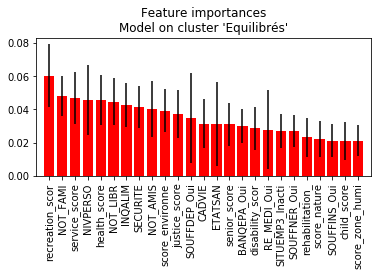

1. feature 13 -recreation_score- (0.060240)
2. feature 9 -NOT_FAMI- (0.048089)
	Actionable at individual level (1)
	Actionable at administrative level (2)
3. feature 11 -service_score- (0.046739)
4. feature 21 -NIVPERSO- (0.045620)
	Actionable at individual level (2)
	Actionable at administrative level (2)
5. feature 26 -health_score- (0.045372)
6. feature 19 -NOT_LIBR- (0.044479)
	Actionable at individual level (1)
	Actionable at administrative level (1)
7. feature 1 -INQALIM- (0.042796)
	Actionable at individual level (1)
	Actionable at administrative level (1)
8. feature 12 -SECURITE- (0.041377)
	Actionable at individual level (2)
	Actionable at administrative level (1)
9. feature 28 -NOT_AMIS- (0.040178)
	Actionable at individual level (1)
	Actionable at administrative level (2)
10. feature 23 -score_environnement- (0.039250)
11. feature 18 -justice_score- (0.037153)
12. feature 27 -SOUFFDEP_Oui- (0.034893)
	Actionable at individual level (2)
	Actionable at administrative level (1)

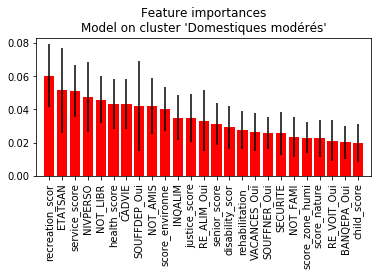

1. feature 13 -recreation_score- (0.060207)
2. feature 2 -ETATSAN- (0.051485)
	Actionable at individual level (1)
	Actionable at administrative level (1)
3. feature 11 -service_score- (0.050973)
4. feature 21 -NIVPERSO- (0.047533)
	Actionable at individual level (2)
	Actionable at administrative level (2)
5. feature 19 -NOT_LIBR- (0.045649)
	Actionable at individual level (1)
	Actionable at administrative level (1)
6. feature 26 -health_score- (0.043495)
7. feature 10 -CADVIE- (0.043246)
	Actionable at individual level (1)
	Actionable at administrative level (1)
8. feature 27 -SOUFFDEP_Oui- (0.042098)
	Actionable at individual level (2)
	Actionable at administrative level (1)
9. feature 28 -NOT_AMIS- (0.041891)
	Actionable at individual level (1)
	Actionable at administrative level (2)
10. feature 23 -score_environnement- (0.040035)
11. feature 1 -INQALIM- (0.035039)
	Actionable at individual level (1)
	Actionable at administrative level (1)
12. feature 18 -justice_score- (0.034880)
13

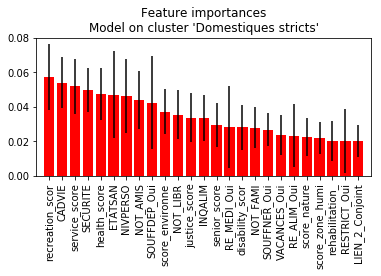

1. feature 13 -recreation_score- (0.057281)
2. feature 10 -CADVIE- (0.053844)
	Actionable at individual level (1)
	Actionable at administrative level (1)
3. feature 11 -service_score- (0.051812)
4. feature 12 -SECURITE- (0.049728)
	Actionable at individual level (2)
	Actionable at administrative level (1)
5. feature 26 -health_score- (0.047156)
6. feature 2 -ETATSAN- (0.047098)
	Actionable at individual level (1)
	Actionable at administrative level (1)
7. feature 21 -NIVPERSO- (0.046260)
	Actionable at individual level (2)
	Actionable at administrative level (2)
8. feature 28 -NOT_AMIS- (0.043982)
	Actionable at individual level (1)
	Actionable at administrative level (2)
9. feature 27 -SOUFFDEP_Oui- (0.042436)
	Actionable at individual level (2)
	Actionable at administrative level (1)
10. feature 23 -score_environnement- (0.037200)
11. feature 19 -NOT_LIBR- (0.035333)
	Actionable at individual level (1)
	Actionable at administrative level (1)
12. feature 18 -justice_score- (0.033776)


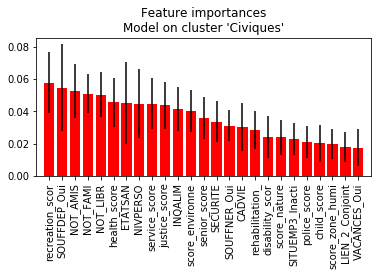

1. feature 13 -recreation_score- (0.057651)
2. feature 27 -SOUFFDEP_Oui- (0.054654)
	Actionable at individual level (2)
	Actionable at administrative level (1)
3. feature 28 -NOT_AMIS- (0.052522)
	Actionable at individual level (1)
	Actionable at administrative level (2)
4. feature 9 -NOT_FAMI- (0.050816)
	Actionable at individual level (1)
	Actionable at administrative level (2)
5. feature 19 -NOT_LIBR- (0.050318)
	Actionable at individual level (1)
	Actionable at administrative level (1)
6. feature 26 -health_score- (0.045595)
7. feature 2 -ETATSAN- (0.044938)
	Actionable at individual level (1)
	Actionable at administrative level (1)
8. feature 21 -NIVPERSO- (0.044766)
	Actionable at individual level (2)
	Actionable at administrative level (2)
9. feature 11 -service_score- (0.044677)
10. feature 18 -justice_score- (0.043685)
11. feature 1 -INQALIM- (0.041439)
	Actionable at individual level (1)
	Actionable at administrative level (1)
12. feature 23 -score_environnement- (0.040245)
1

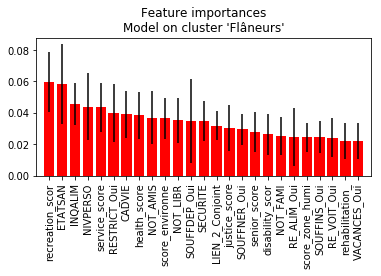

1. feature 13 -recreation_score- (0.059557)
2. feature 2 -ETATSAN- (0.058241)
	Actionable at individual level (1)
	Actionable at administrative level (1)
3. feature 1 -INQALIM- (0.045958)
	Actionable at individual level (1)
	Actionable at administrative level (1)
4. feature 21 -NIVPERSO- (0.043906)
	Actionable at individual level (2)
	Actionable at administrative level (2)
5. feature 11 -service_score- (0.043523)
6. feature 17 -RESTRICT_Oui- (0.040118)
	Actionable at individual level (2)
	Actionable at administrative level (2)
7. feature 10 -CADVIE- (0.039059)
	Actionable at individual level (1)
	Actionable at administrative level (1)
8. feature 26 -health_score- (0.038479)
9. feature 28 -NOT_AMIS- (0.037006)
	Actionable at individual level (1)
	Actionable at administrative level (2)
10. feature 23 -score_environnement- (0.036567)
11. feature 19 -NOT_LIBR- (0.035219)
	Actionable at individual level (1)
	Actionable at administrative level (1)
12. feature 27 -SOUFFDEP_Oui- (0.034982)
	Ac

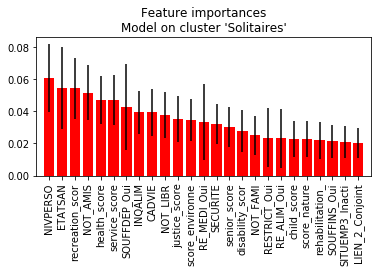

1. feature 21 -NIVPERSO- (0.060923)
	Actionable at individual level (2)
	Actionable at administrative level (2)
2. feature 2 -ETATSAN- (0.054585)
	Actionable at individual level (1)
	Actionable at administrative level (1)
3. feature 13 -recreation_score- (0.054377)
4. feature 28 -NOT_AMIS- (0.051651)
	Actionable at individual level (1)
	Actionable at administrative level (2)
5. feature 26 -health_score- (0.047141)
6. feature 11 -service_score- (0.046994)
7. feature 27 -SOUFFDEP_Oui- (0.042860)
	Actionable at individual level (2)
	Actionable at administrative level (1)
8. feature 1 -INQALIM- (0.039438)
	Actionable at individual level (1)
	Actionable at administrative level (1)
9. feature 10 -CADVIE- (0.039396)
	Actionable at individual level (1)
	Actionable at administrative level (1)
10. feature 19 -NOT_LIBR- (0.037676)
	Actionable at individual level (1)
	Actionable at administrative level (1)
11. feature 18 -justice_score- (0.035045)
12. feature 23 -score_environnement- (0.034700)
13

In [29]:
# Feature importance by cluster
for score_method in score_clustering_methods:
    print(f"method {score_method['clustering_method']}:")
    for i, score_cluster in enumerate(score_method['cluster_scores']):
        print(f"cluster {score_cluster['cluster']} ({score_cluster['size']}), f1 macro {100*score_cluster['metrics']['f1_score']:0.1f}%")
        print(f"top 15 features:")
        indices = score_cluster['indices']
        features_name = score_cluster['features_name']
        importances = score_cluster['importances']
        features_short_name_sorted = [ name[:15] for name in features_name[indices]]
          
        # Plot the feature importances of the forest       
        plt.figure()
        plt.gcf().subplots_adjust(bottom=0.4)
        plt.title(f"Feature importances\nModel on cluster '{cluster_name[score_cluster['cluster']]}'")
        plt.bar(range(n_features), importances[indices][:n_features],
                color="r", yerr=std[indices][:n_features], align="center")
        plt.xticks(range(n_features), features_short_name_sorted[:n_features], rotation=90)
        plt.xlim([-1, n_features])
        filename = path_fig / Path(f"feature_importance_cluster_{score_cluster['cluster']}_option2.jpg")
        plt.savefig(filename, format='jpg')
        plt.show()
                
        for f in range(n_features_max):
            print("%d. feature %d -%s- (%f)" % (f + 1, indices[f],features_name[indices[f]], importances[indices[f]]))
            if features_name[indices[f]] in actionable_individual_1_features:
                print("\tActionable at individual level (1)")
            if features_name[indices[f]] in actionable_individual_2_features:
                print("\tActionable at individual level (2)")
            if features_name[indices[f]] in actionable_admin_1_features:
                print("\tActionable at administrative level (1)")
            if features_name[indices[f]] in actionable_admin_2_features:
                print("\tActionable at administrative level (2)")

## Option 3

In [30]:
# choosing set of features
scope_filter = RFE_RandomForestClassifier_100_features | RFE_LinearSVC_100_features
scope = dict_features_sets.get('insee_environment_score_features', set())
scope = scope | dict_features_sets.get('insee_recreation_score_features',set()) 
scope = scope | dict_features_sets.get('cdv_actionable_admin_1_features',set()) 
scope = scope | dict_features_sets.get('cdv_actionable_individual_1_features',set()) 
scope = scope | RFE_LogisticRegression_20_features
scope =  scope & scope_filter
print(f"number of features : {len(scope)} ow actionable")
A = scope & dict_features_sets.get('cdv_actionable_admin_1_features',set()) 
B = scope & dict_features_sets.get('cdv_actionable_individual_1_features',set()) 
print(f"- at administrative level 1 : \t{len(A)}\n- at individual level 1 : \t{len(B)}")

number of features : 40 ow actionable
- at administrative level 1 : 	29
- at individual level 1 : 	26


In [31]:
df = dataset.loc[:,:]
# reducing problem to a 2 class classification problem
df["HEUREUX_CLF"] = 0
df.loc[df["HEUREUX"]==4, "HEUREUX_CLF"] = 1
df.loc[df["HEUREUX"]==3, "HEUREUX_CLF"] = 1
df.loc[df["HEUREUX"]==5, "HEUREUX_CLF"] = None

scope = scope & set(dataset.columns)
n_max = 2000

df = df.loc[:,scope | {"HEUREUX_CLF"} ].dropna()
features = df.loc[:,scope ].columns

X = df.loc[:,scope]
y = df["HEUREUX_CLF"]


Xs, ys = resample(X, y, random_state=42)

Xs = Xs.iloc[0:n_max,:]
ys = ys.iloc[0:n_max]

X_train, X_test, y_train, y_test = train_test_split(Xs, ys, 
                                                    test_size=0.2, 
                                                    random_state=42
                                                   )

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f"Number exemple: {y.shape[0]}\n- training set: \
{y_train.shape[0]}\n- test set: {y_test.shape[0]}")
print(f"Number of features: p={X_train.shape[1]}")
print(f"Number of class: {len(np.unique(y))}")
for c in np.unique(y):
    print(f"class {c:0.0f} : {100*np.sum(y==c)/len(y):0.1f}%")

Number exemple: 10605
- training set: 1600
- test set: 400
Number of features: p=40
Number of class: 2
class 0 : 34.9%
class 1 : 65.1%


In [32]:
startTime = time.time()
n_estimators_range = [32,64,128,256,512]
max_depth_range = [4,8,16,32,64] 
param_grid = dict(n_estimators=n_estimators_range, max_depth = max_depth_range)

params = {'max_features' :'sqrt', 'random_state' : 32,
          'min_samples_split' : 2, 'class_weight' : 'balanced'}
clf = RandomForestClassifier(**params)

grid = GridSearchCV(clf, scoring='accuracy', param_grid=param_grid)
grid.fit(X_train, y_train)
print(f"Determination of optimal hyperparameters in {time.time() - startTime:0.1f} s")
print(f"Optimal values are {grid.best_params_} \n\
Accuracy Score of cross valdation {100*grid.best_score_:0.2f}%")

# Learning on full training set with optimals hyperparameters and score on test set
params = {'max_features' :'sqrt', 'random_state' : 32, 
          'min_samples_split' : 2, 'class_weight' : 'balanced',
          'n_estimators' : grid.best_params_['n_estimators'],
          'max_depth' : grid.best_params_['max_depth']}
clf = RandomForestClassifier(**params).fit(X_train, y_train)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

print(f"Random Forest, p={X_train.shape[1]}")
accuracy = clf.score(X_test, y_test)
f1 = f1_score(y_test, y_test_pred)
p = precision_score(y_test, y_test_pred)
r = recall_score(y_test, y_test_pred)
print(f"Model score\n- Accuracy : {accuracy*100:0.1f} %")
print(f"- Precision : {p*100:0.1f} % (Happy # positive class)")
print(f"- Recall : {r*100:0.1f} %")
print(f"- F1 score : {f1*100:0.1f} %")
res_full  = {
    'f1_score' : f1,
    'accuracy' : accuracy,
    'precision' : p,
    'recall' : r
}

Determination of optimal hyperparameters in 61.3 s
Optimal values are {'max_depth': 16, 'n_estimators': 512} 
Accuracy Score of cross valdation 75.88%
Random Forest, p=40
Model score
- Accuracy : 73.0 %
- Precision : 75.3 % (Happy # positive class)
- Recall : 85.4 %
- F1 score : 80.0 %


Feature ranking:


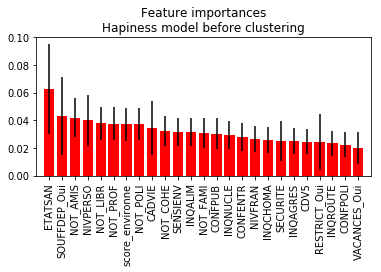

1. feature 3 -ETATSAN- (0.062689)
	Actionable at individual level (1)
	Actionable at administrative level (1)
2. feature 35 -SOUFFDEP_Oui- (0.042963)
	Actionable at individual level (2)
	Actionable at administrative level (1)
3. feature 36 -NOT_AMIS- (0.041908)
	Actionable at individual level (1)
	Actionable at administrative level (2)
4. feature 27 -NIVPERSO- (0.039819)
	Actionable at individual level (2)
	Actionable at administrative level (2)
5. feature 24 -NOT_LIBR- (0.037761)
	Actionable at individual level (1)
	Actionable at administrative level (1)
6. feature 26 -NOT_PROF- (0.037372)
	Actionable at individual level (1)
	Actionable at administrative level (2)
7. feature 28 -score_environnement- (0.037163)
8. feature 33 -NOT_POLI- (0.037133)
	Actionable at individual level (1)
	Actionable at administrative level (1)
9. feature 16 -CADVIE- (0.034626)
	Actionable at individual level (1)
	Actionable at administrative level (1)
10. feature 31 -NOT_COHE- (0.032463)
	Actionable at indiv

In [33]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features_name = np.array(features)
features_short_name_sorted = [ name[:15] for name in features_name[indices]]
print("Feature ranking:")

n_features_max = 25
n_features = min(X.shape[1],n_features_max)

# Plot the feature importances of the forest

plt.figure()
plt.gcf().subplots_adjust(bottom=0.4)
plt.title("Feature importances\nHapiness model before clustering")
plt.bar(range(n_features), importances[indices][:n_features],
        color="r", yerr=std[indices[:n_features]], align="center")
plt.xticks(range(n_features), features_short_name_sorted[:n_features], rotation=90)
plt.xlim([-1, n_features])
filename = path_fig / Path("feature_importance_option3.jpg")
plt.savefig(filename, format='jpg')
plt.show()

for f in range(min(X.shape[1],n_features_max)):
    print("%d. feature %d -%s- (%f)" % (f + 1, indices[f],features_name[indices[f]], importances[indices[f]]))
    if features_name[indices[f]] in actionable_individual_1_features:
        print("\tActionable at individual level (1)")
    if features_name[indices[f]] in actionable_individual_2_features:
        print("\tActionable at individual level (2)")
    if features_name[indices[f]] in actionable_admin_1_features:
        print("\tActionable at administrative level (1)")
    if features_name[indices[f]] in actionable_admin_2_features:
        print("\tActionable at administrative level (2)")

In [34]:
print(f"number of features : {len(scope)} ow actionnable")
A = scope & dict_features_sets.get('cdv_actionable_admin_1_features',set()) 
B = scope & dict_features_sets.get('cdv_actionable_individual_1_features',set()) 
print(f"- at administrative level 1 : \t{len(A)}\n- at individual level 1 : \t{len(B)}")
important_features = set(features_name[indices][:10])
C = A & important_features
D = B & important_features
print(f"- at administrative level 1 in top 10: \t{len(C)}\n- at individual level 1 in top 10: \t{len(D)}")

number of features : 40 ow actionnable
- at administrative level 1 : 	29
- at individual level 1 : 	26
- at administrative level 1 in top 10: 	6
- at individual level 1 in top 10: 	7


In [35]:
n_estimators_range = [16,32,64,128]
max_depth_range = [2,4,8,16,32,64] 
param_grid = dict(n_estimators=n_estimators_range, max_depth = max_depth_range)
params = {'max_features' :'sqrt', 
          'random_state' : 32, 
          'min_samples_split' : 2, 
          'class_weight' : 'balanced'
         }
#scope = ( SelectFromModel_LogisticRegression_features )  & set(dataset.columns)
features = df.loc[:,scope].columns

In [36]:
score_clustering_methods = []
clustering_methods = clustTest1.columns[2:3]

for method in clustering_methods:
    print("--------------------------------------------")
    print(f"\nAnalysis cluster method {method}")
    cluster_list = clustTest1[method].unique()
    print(f"liste of clusters : {cluster_list}")
    score_cluster = []
    for cluster in cluster_list:
        index_scope = clustTest1.loc[clustTest1[method]==cluster,:].index
        print(f"cluster {cluster} '{cluster_name[cluster]}' : {len(index_scope)} elements")
        
        Xc = X.loc[index_scope.intersection(X.index),:]
        yc = y[index_scope.intersection(X.index)]
        
        Xs, ys = resample(Xc, yc, random_state=42)
        
        Xs = Xs.iloc[0:n_max,:]
        ys = ys.iloc[0:n_max]
        
        X_train, X_test, y_train, y_test = train_test_split(Xs, ys,
                                                            test_size=0.2, 
                                                            random_state=42)

        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
                
        print(f"Number exemple: {ys.shape[0]}\n\
        - training set: {y_train.shape[0]}\n\
        - test set: {y_test.shape[0]}")
        print(f"Number of features: p={X_train.shape[1]}")
        print(f"Number of class: {len(np.unique(y))}")
        for c in np.unique(y):
            print(f"class {c:0.0f} : {100*np.sum(yc==c)/len(yc):0.1f}%")
            
            
        startTime = time.time()
        clf = RandomForestClassifier(**params)
        grid = GridSearchCV(clf, 
                            scoring='accuracy', 
                            param_grid=param_grid)

        grid.fit(X_train, y_train)
        print(f"Optimal values are {grid.best_params_} \n\
cross validation score {100*grid.best_score_:0.2f}%")
        print()

        # Learning on full training set with optimals hyperparameters and score on test set
        params_opt = {'max_features' :'sqrt', 'random_state' : 32, 
                      'min_samples_split' : 2, 'class_weight' : 'balanced',
                      'n_estimators' : grid.best_params_['n_estimators'],
                      'max_depth' : grid.best_params_['max_depth']}
        clf = RandomForestClassifier(**params_opt).fit(X_train, y_train)

            
        y_test_pred = clf.predict(X_test)
        accuracy = clf.score(X_test, y_test)
        f1 = f1_score(y_test, y_test_pred)
        p = precision_score(y_test, y_test_pred)
        r = recall_score(y_test, y_test_pred)            

        res  = {'f1_score' : f1,
                'accuracy' : accuracy,
                'precision' : p,
                'recall' : r}

        
        importances = clf.feature_importances_
        std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                     axis=0)
        indices = np.argsort(importances)[::-1]
        features_name = np.array(features)
        
        cl = {'cluster' : cluster,
              'size' : len(index_scope),
              'model' : 'RandomForestClassifier',
              'params' : params_opt,
              'metrics' : res,
              'importances' : importances,
              'sdt' : std,
              'indices' : indices,
              'features_name' : features_name
             }
         
        score_cluster.append(cl)        
        
        
    d = {'clustering_method' : method,
         'cluster_scores' : score_cluster
        }
    score_clustering_methods.append(d)

--------------------------------------------

Analysis cluster method clust3
liste of clusters : [2 4 6 1 3 5]
cluster 2 'Equilibrés' : 3053 elements
Number exemple: 2000
        - training set: 1600
        - test set: 400
Number of features: p=40
Number of class: 2
class 0 : 34.6%
class 1 : 65.4%
Optimal values are {'max_depth': 16, 'n_estimators': 64} 
cross validation score 81.94%

cluster 4 'Domestiques modérés' : 2359 elements
Number exemple: 2000
        - training set: 1600
        - test set: 400
Number of features: p=40
Number of class: 2
class 0 : 32.6%
class 1 : 67.4%
Optimal values are {'max_depth': 16, 'n_estimators': 128} 
cross validation score 83.94%

cluster 6 'Domestiques stricts' : 2313 elements
Number exemple: 2000
        - training set: 1600
        - test set: 400
Number of features: p=40
Number of class: 2
class 0 : 32.8%
class 1 : 67.2%
Optimal values are {'max_depth': 32, 'n_estimators': 128} 
cross validation score 83.12%

cluster 1 'Civiques' : 528 elements

In [37]:
# F1 score
for score_method in score_clustering_methods:
    print(f"method {score_method['clustering_method']}:")
    average_score = 0
    total_size = 0
    for i, score_cluster in enumerate(score_method['cluster_scores']):
        print(f"cluster {score_cluster['cluster']} '{cluster_name[score_cluster['cluster']]}' : ({score_cluster['size']}), f1 macro {100*score_cluster['metrics']['f1_score']:0.1f}%")  
        average_score += score_cluster['metrics']['f1_score']*score_cluster['size']
        total_size += score_cluster['size']
        
    average_score = average_score / total_size
    print(f"average f1 on clusters {100*average_score:0.1f}% gain {100*(average_score-res_full['f1_score']):0.1f}\n")

method clust3:
cluster 2 'Equilibrés' : (3053), f1 macro 85.6%
cluster 4 'Domestiques modérés' : (2359), f1 macro 90.5%
cluster 6 'Domestiques stricts' : (2313), f1 macro 90.4%
cluster 1 'Civiques' : (528), f1 macro 92.1%
cluster 3 'Flâneurs' : (1384), f1 macro 95.4%
cluster 5 'Solitaires' : (1494), f1 macro 87.8%
average f1 on clusters 89.5% gain 9.5



In [38]:
# accuracy
for score_method in score_clustering_methods:
    print(f"method {score_method['clustering_method']}:")
    average_score = 0
    total_size = 0
    for i, score_cluster in enumerate(score_method['cluster_scores']):
        print(f"cluster {score_cluster['cluster']} '{cluster_name[score_cluster['cluster']]}' : ({score_cluster['size']}) accuracy {100*score_cluster['metrics']['accuracy']:0.1f}%")  
        average_score = average_score + score_cluster['metrics']['accuracy']*score_cluster['size']
        total_size += score_cluster['size']
    average_score = average_score / total_size
    print(f"average accuracy on clusters {100*average_score:0.1f}% gain {100*(average_score-res_full['accuracy']):0.1f}\n")  

method clust3:
cluster 2 'Equilibrés' : (3053) accuracy 81.5%
cluster 4 'Domestiques modérés' : (2359) accuracy 86.8%
cluster 6 'Domestiques stricts' : (2313) accuracy 86.2%
cluster 1 'Civiques' : (528) accuracy 92.6%
cluster 3 'Flâneurs' : (1384) accuracy 93.3%
cluster 5 'Solitaires' : (1494) accuracy 84.5%
average accuracy on clusters 86.0% gain 13.0



method clust3:
cluster 2 (3053), f1 macro 85.6%
top 15 features:


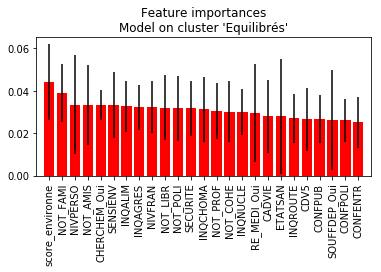

1. feature 28 -score_environnement- (0.044090)
2. feature 14 -NOT_FAMI- (0.038867)
	Actionable at individual level (1)
	Actionable at administrative level (2)
3. feature 27 -NIVPERSO- (0.033454)
	Actionable at individual level (2)
	Actionable at administrative level (2)
4. feature 36 -NOT_AMIS- (0.033307)
	Actionable at individual level (1)
	Actionable at administrative level (2)
5. feature 22 -CHERCHEM_Oui- (0.033212)
	Actionable at individual level (1)
	Actionable at administrative level (2)
6. feature 32 -SENSIENV- (0.033058)
	Actionable at individual level (1)
	Actionable at administrative level (1)
7. feature 2 -INQALIM- (0.032553)
	Actionable at individual level (1)
	Actionable at administrative level (1)
8. feature 9 -INQAGRES- (0.032290)
	Actionable at individual level (1)
	Actionable at administrative level (1)
9. feature 8 -NIVFRAN- (0.032261)
	Actionable at individual level (2)
	Actionable at administrative level (1)
10. feature 24 -NOT_LIBR- (0.031972)
	Actionable at indivi

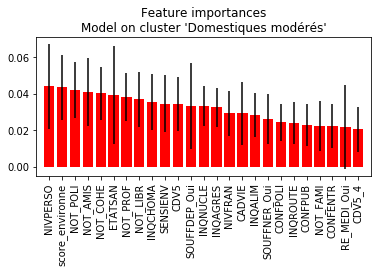

1. feature 27 -NIVPERSO- (0.043900)
	Actionable at individual level (2)
	Actionable at administrative level (2)
2. feature 28 -score_environnement- (0.043421)
3. feature 33 -NOT_POLI- (0.041819)
	Actionable at individual level (1)
	Actionable at administrative level (1)
4. feature 36 -NOT_AMIS- (0.040947)
	Actionable at individual level (1)
	Actionable at administrative level (2)
5. feature 31 -NOT_COHE- (0.040179)
	Actionable at individual level (1)
	Actionable at administrative level (1)
6. feature 3 -ETATSAN- (0.039159)
	Actionable at individual level (1)
	Actionable at administrative level (1)
7. feature 26 -NOT_PROF- (0.038041)
	Actionable at individual level (1)
	Actionable at administrative level (2)
8. feature 24 -NOT_LIBR- (0.036783)
	Actionable at individual level (1)
	Actionable at administrative level (1)
9. feature 20 -INQCHOMA- (0.035285)
	Actionable at individual level (1)
	Actionable at administrative level (1)
10. feature 32 -SENSIENV- (0.034527)
	Actionable at individ

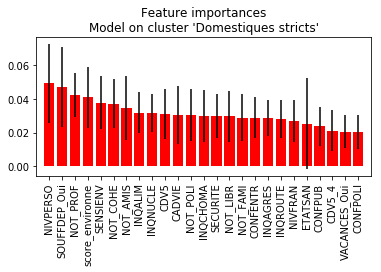

1. feature 27 -NIVPERSO- (0.048936)
	Actionable at individual level (2)
	Actionable at administrative level (2)
2. feature 35 -SOUFFDEP_Oui- (0.046825)
	Actionable at individual level (2)
	Actionable at administrative level (1)
3. feature 26 -NOT_PROF- (0.042092)
	Actionable at individual level (1)
	Actionable at administrative level (2)
4. feature 28 -score_environnement- (0.040757)
5. feature 32 -SENSIENV- (0.037539)
	Actionable at individual level (1)
	Actionable at administrative level (1)
6. feature 31 -NOT_COHE- (0.036953)
	Actionable at individual level (1)
	Actionable at administrative level (1)
7. feature 36 -NOT_AMIS- (0.034509)
	Actionable at individual level (1)
	Actionable at administrative level (2)
8. feature 2 -INQALIM- (0.031748)
	Actionable at individual level (1)
	Actionable at administrative level (1)
9. feature 39 -INQNUCLE- (0.031542)
	Actionable at individual level (1)
	Actionable at administrative level (1)
10. feature 7 -CDV5- (0.031029)
	Actionable at individu

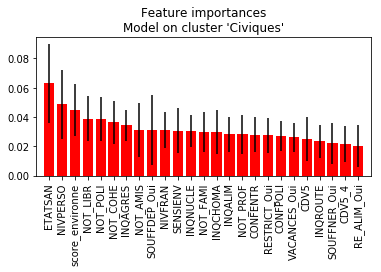

1. feature 3 -ETATSAN- (0.063048)
	Actionable at individual level (1)
	Actionable at administrative level (1)
2. feature 27 -NIVPERSO- (0.048830)
	Actionable at individual level (2)
	Actionable at administrative level (2)
3. feature 28 -score_environnement- (0.044799)
4. feature 24 -NOT_LIBR- (0.038897)
	Actionable at individual level (1)
	Actionable at administrative level (1)
5. feature 33 -NOT_POLI- (0.038633)
	Actionable at individual level (1)
	Actionable at administrative level (1)
6. feature 31 -NOT_COHE- (0.036256)
	Actionable at individual level (1)
	Actionable at administrative level (1)
7. feature 9 -INQAGRES- (0.034210)
	Actionable at individual level (1)
	Actionable at administrative level (1)
8. feature 36 -NOT_AMIS- (0.031163)
	Actionable at individual level (1)
	Actionable at administrative level (2)
9. feature 35 -SOUFFDEP_Oui- (0.031066)
	Actionable at individual level (2)
	Actionable at administrative level (1)
10. feature 8 -NIVFRAN- (0.030870)
	Actionable at indivi

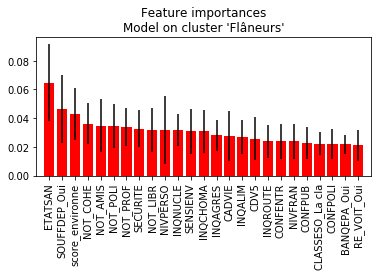

1. feature 3 -ETATSAN- (0.064748)
	Actionable at individual level (1)
	Actionable at administrative level (1)
2. feature 35 -SOUFFDEP_Oui- (0.046520)
	Actionable at individual level (2)
	Actionable at administrative level (1)
3. feature 28 -score_environnement- (0.042737)
4. feature 31 -NOT_COHE- (0.036064)
	Actionable at individual level (1)
	Actionable at administrative level (1)
5. feature 36 -NOT_AMIS- (0.034809)
	Actionable at individual level (1)
	Actionable at administrative level (2)
6. feature 33 -NOT_POLI- (0.034676)
	Actionable at individual level (1)
	Actionable at administrative level (1)
7. feature 26 -NOT_PROF- (0.033644)
	Actionable at individual level (1)
	Actionable at administrative level (2)
8. feature 17 -SECURITE- (0.032646)
	Actionable at individual level (2)
	Actionable at administrative level (1)
9. feature 24 -NOT_LIBR- (0.031848)
	Actionable at individual level (1)
	Actionable at administrative level (1)
10. feature 27 -NIVPERSO- (0.031829)
	Actionable at ind

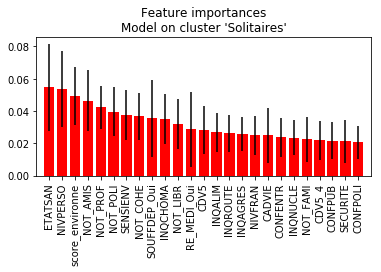

1. feature 3 -ETATSAN- (0.054595)
	Actionable at individual level (1)
	Actionable at administrative level (1)
2. feature 27 -NIVPERSO- (0.053860)
	Actionable at individual level (2)
	Actionable at administrative level (2)
3. feature 28 -score_environnement- (0.048987)
4. feature 36 -NOT_AMIS- (0.046352)
	Actionable at individual level (1)
	Actionable at administrative level (2)
5. feature 26 -NOT_PROF- (0.042180)
	Actionable at individual level (1)
	Actionable at administrative level (2)
6. feature 33 -NOT_POLI- (0.039579)
	Actionable at individual level (1)
	Actionable at administrative level (1)
7. feature 32 -SENSIENV- (0.037516)
	Actionable at individual level (1)
	Actionable at administrative level (1)
8. feature 31 -NOT_COHE- (0.036678)
	Actionable at individual level (1)
	Actionable at administrative level (1)
9. feature 35 -SOUFFDEP_Oui- (0.035340)
	Actionable at individual level (2)
	Actionable at administrative level (1)
10. feature 20 -INQCHOMA- (0.034935)
	Actionable at ind

In [39]:
# Feature importance by cluster
for score_method in score_clustering_methods:
    print(f"method {score_method['clustering_method']}:")
    for i, score_cluster in enumerate(score_method['cluster_scores']):
        print(f"cluster {score_cluster['cluster']} ({score_cluster['size']}), f1 macro {100*score_cluster['metrics']['f1_score']:0.1f}%")
        print(f"top 15 features:")
        indices = score_cluster['indices']
        features_name = score_cluster['features_name']
        importances = score_cluster['importances']
        features_short_name_sorted = [ name[:15] for name in features_name[indices]]
          
        # Plot the feature importances of the forest       
        plt.figure()
        plt.gcf().subplots_adjust(bottom=0.4)
        plt.title(f"Feature importances\nModel on cluster '{cluster_name[score_cluster['cluster']]}'")
        plt.bar(range(n_features), importances[indices][:n_features],
                color="r", yerr=std[indices][:n_features], align="center")
        plt.xticks(range(n_features), features_short_name_sorted[:n_features], rotation=90)
        plt.xlim([-1, n_features])
        filename = path_fig / Path(f"feature_importance_cluster_{score_cluster['cluster']}_option3.jpg")
        plt.savefig(filename, format='jpg')
        plt.show()
                
        for f in range(n_features_max):
            print("%d. feature %d -%s- (%f)" % (f + 1, indices[f],features_name[indices[f]], importances[indices[f]]))
            if features_name[indices[f]] in actionable_individual_1_features:
                print("\tActionable at individual level (1)")
            if features_name[indices[f]] in actionable_individual_2_features:
                print("\tActionable at individual level (2)")
            if features_name[indices[f]] in actionable_admin_1_features:
                print("\tActionable at administrative level (1)")
            if features_name[indices[f]] in actionable_admin_2_features:
                print("\tActionable at administrative level (2)")